In [1]:
# import libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import collections
import helpers
from helpers import *
import pickle

In [2]:
%pwd

'/Users/thomasspringett/github/heartrate'

In [3]:
csv_file = 'data/HeartRateData.csv'
df_raw = pd.read_csv(csv_file)
df_raw=df_raw.drop('DateTime',1)
df_raw.head()

,BPM
0,77
1,69
2,69
3,69
4,69


In [4]:
print (round(df_raw.BPM.describe()))


count    349768.0
mean         78.0
std          24.0
min          30.0
25%          61.0
50%          69.0
75%          86.0
max         215.0
Name: BPM, dtype: float64


In [5]:
def zones(df_raw, age):
    max_hr = 220 - age
    target_low = 0.64*max_hr
    target_high = 0.76*max_hr
    target_intensity_lo = 0.76*max_hr
    target_intensity_hi = 0.93*max_hr
    print ("For Age: {} Maximum HR: {}".format(age,max_hr))
    print ("Target HR Lower Bound:", target_low)
    print ("Target HR Upper Bound:", target_high)
    print ("Target HR Intensity Upper Bound:", target_intensity_hi)
    return max_hr, target_low, target_high, target_intensity_lo, target_intensity_hi

In [6]:
max_hr, target_low, target_high, target_intensity_lo, target_intensity_hi = zones(df_raw,62)

For Age: 62 Maximum HR: 158
Target HR Lower Bound: 101.12
Target HR Upper Bound: 120.08
Target HR Intensity Upper Bound: 146.94


In [7]:
def plot_data_histo(totals): 
    #Histogram of the number of missing values per column (featrure).
    xref = [max_hr,target_low, target_high,target_intensity_hi]
    ref_colors=['r','g','y','b']

    for ref, c in zip(xref,ref_colors):
        plt.axvline(x=ref, c=c, label= 'ref at = {}'.format(ref))
    plt.legend()
    plt.grid(True)
    plt.xlabel('Beats/Minute')
    plt.ylabel('Count')
    plt.title('Heart Rate Distribution')
    plt.hist(df_raw.BPM,50)
    plt.show()

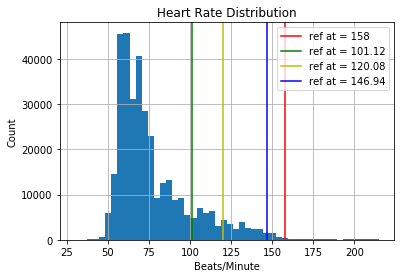

In [8]:
#print (df.BPM)
plot_data_histo(df_raw.BPM)

In [9]:
#df_raw.BPM.quantile([0.95,0.98,0.99])

In [10]:
hardware_limit = 210
df = df_raw[(df_raw.BPM < hardware_limit)]
num_screened = df_raw.shape[0]-df.shape[0]
print ("Applying hardware limit of {}bpm resulted in dropping {} data points.".format(hardware_limit,num_screened))

Applying hardware limit of 210bpm resulted in dropping 314 data points.


In [11]:

def scree_KMeans_plot(data,num_clusters):
    clusterCenters = [] 
    scores = [] 
    k_values = []
    start = timer()
    for k in range(1,num_clusters):
        k_values.append(k)
        kmeans = KMeans(n_clusters=k)
        model = kmeans.fit(data)
        print ("\nCluster {}: {}".format(k,model.cluster_centers_))
        clusterCenters.append(model.cluster_centers_)
        labels = kmeans.predict(data)
        print ("Cluster Label: ",labels)
        score = -(kmeans.score(data))
        print ("score: ",round(score/100000000,2))
        scores.append(score)
    plt.plot(k_values, scores, marker = 'o')
    plt.ylabel('K-Cluster Score')
    plt.xlabel('k value')
    plt.title('Number of Clusters vs KMeans Score')
    plt.savefig('Cluster_vs_score_plot.png')
    plt.show()
    end = timer() 
    print(f"\nFunction in {(end - start)/60:0.1f} minutes")
    return k_values, scores, labels


Cluster 1: [[77.52634109]]
Cluster Label:  [0 0 0 ... 0 0 0]
score:  1.89

Cluster 2: [[ 67.39849131]
 [115.66932624]]
Cluster Label:  [0 0 0 ... 0 0 0]
score:  0.54

Cluster 3: [[ 63.25309656]
 [127.76962689]
 [ 87.68667061]]
Cluster Label:  [2 0 0 ... 0 0 0]
score:  0.28

Cluster 4: [[ 79.5248856 ]
 [139.43676297]
 [ 61.66033189]
 [106.04943661]]
Cluster Label:  [0 2 2 ... 2 2 2]
score:  0.17

Cluster 5: [[ 72.19019568]
 [117.01270921]
 [ 91.34488255]
 [ 59.53639126]
 [147.52834937]]
Cluster Label:  [0 0 0 ... 3 3 3]
score:  0.12

Cluster 6: [[ 59.79014096]
 [ 89.59052412]
 [183.74633861]
 [111.17730665]
 [ 72.53475973]
 [137.00077692]]
Cluster Label:  [4 4 4 ... 0 0 0]
score:  0.09

Cluster 7: [[ 80.78030018]
 [114.90026485]
 [ 58.39574023]
 [138.17887525]
 [183.74633861]
 [ 96.30282033]
 [ 68.44468475]]
Cluster Label:  [0 6 6 ... 2 2 2]
score:  0.06

Cluster 8: [[ 57.91997182]
 [ 90.89587328]
 [126.24728659]
 [ 77.53533437]
 [144.84094667]
 [ 67.00769094]
 [107.99964441]
 [187.345

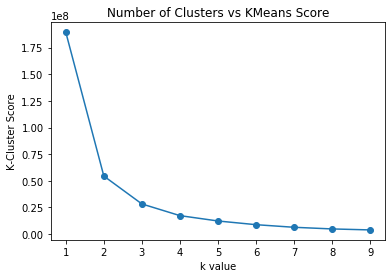


Function in 0.3 minutes


In [12]:
k_values, scores, labels = scree_KMeans_plot(df,10) 
k = zip(k_values, scores)
print (k)

In [13]:
if not 'Label' in df: 
    df.insert(1,"Label",labels)
df.tail(5)

,BPM,Label
349762,62,2
349763,67,5
349764,61,2
349765,63,5
349766,62,2


In [14]:
print ("KMeans Labels: ",np.unique(labels))     

KMeans Labels:  [0 1 2 3 4 5 6 7 8]


In [15]:
for score in scores:
    print (round(score/100000000,2))
def findK(df,limit): 
    for k in range(len(df)):
        if k > 0:
          improvement = (round(100*((df[k-1]-df[k])/df[k])))
          print (k,round(df[k]/100000000,2),improvement)
          if improvement < limit:
                break 
    print ("Less than {}% improvement in score after k = {}".format(limit,k))
findK(scores,10)      

1.89
0.54
0.28
0.17
0.12
0.09
0.06
0.05
0.04
1 0.54 248.0
2 0.28 92.0
3 0.17 63.0
4 0.12 41.0
5 0.09 39.0
6 0.06 38.0
7 0.05 32.0
8 0.04 23.0
Less than 10% improvement in score after k = 8


In [16]:
%%time
def silhouetteScore(df): 
    sil_scores = [] 
    start = timer()
    range_n_clusters = list(range(1,10))
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = kmeans.fit_predict(df)
        score = silhouette_score(df,cluster_labels)
        sil_scores.append(score)
        print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))
        end=timer()
        print(f"\nFunction in {(end - start)/60:0.1f} minutes")
    print ("\nFinished!")
    return sil_scores

CPU times: user 7 µs, sys: 3 µs, total: 10 µs
Wall time: 21.9 µs


In [17]:
#sil_scores = silhouetteScore(df)

In [18]:
#pickle.dump(sil_scores,open('data/silhouetteScores','wb'))
silhouette = pickle.load(open('data/silhouetteScores', 'rb'))
print ("Sil Scores: ",silhouette)

Sil Scores:  [0.6898181825990433, 0.5874511324301963, 0.5535071353160601, 0.5660426272202901, 0.5787567554857502, 0.5823607690806277, 0.6260014148168749, 0.6373106436985563]


In [ ]:
def silhouette_plot(scores, k_values):

    plt.ylabel('Silhouette Score')
    plt.xlabel('k value')
    plt.title('Silhouete For Best K')
    plt.ylim=(0.0,1.0)
    plt.grid(True)
    plt.plot(k_values, scores, marker = 'o')
    plt.show()

In [ ]:
print (len(k_values), len(silhouette))
oftype(k_values)
oftype(silhouette)
if len(k_values) > len(silhouette):
    k_values = k_values[:-1]
oftype(k_values)

In [ ]:
silhouette_plot(silhouette,k_values)

/Users/thomasspringett/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,



Cluster <zip object at 0x7f9f3359a9c8>: [[ 67.39849131]
 [115.66932624]]
KMeans Labels:  [0 1]
   BPM  Label
0   77      0
1   69      0
2   69      0
3   69      0
4   69      0
cluster0.shape:  (276134, 2)
cluster1.shape:  (73320, 2)


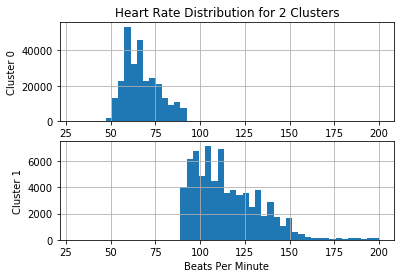

In [19]:
def clusters_plot(df,num_clusters):
    
    if  'Label' in df: 
        df.drop("Label",axis='columns',inplace=True)
    kmeans = KMeans(n_clusters=num_clusters)
    model = kmeans.fit(df)
    print ("\nCluster {}: {}".format(k,model.cluster_centers_))
    labels = kmeans.predict(df)
    print ("KMeans Labels: ",np.unique(labels))   
   
    df.insert(1,"Label",labels)
 
    cluster0 = df.loc[df['Label'] == 0]
    cluster1 = df.loc[df['Label'] == 1]
    
    print ("cluster0.shape: ",cluster0.shape)
    print ("cluster1.shape: ",cluster1.shape)
    #print (cluster0.head())
    #print (cluster1.head())
    
    bins = np.linspace(30, 200, 50)
    plt.subplot(2,1,1)
    plt.hist(cluster0.BPM,bins)
    plt.title('Heart Rate Distribution for 2 Clusters')
  
    plt.grid(True)
    plt.ylabel('Cluster 0')
    
    plt.subplot(2,1,2)
    plt.hist(cluster1.BPM,bins) 
    plt.xlabel('Beats Per Minute')
    plt.ylabel('Cluster 1')
    plt.grid(True)
    plt.show()
        
clusters_plot(df,2)

/Users/thomasspringett/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,



Cluster <zip object at 0x7f9f3359a9c8>: [[ 63.25309656]
 [127.76962689]
 [ 87.68667061]]
KMeans Labels:  [0 1 2]
   BPM  Label
0   77      2
1   69      0
2   69      0
3   69      0
4   69      0
cluster0.shape:  (215400, 2)
cluster1.shape:  (42722, 2)


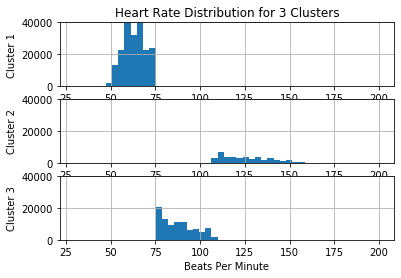

In [20]:
def clusters_plot(df,num_clusters):
    
    if  'Label' in df: 
        df.drop("Label",axis='columns',inplace=True)
    kmeans = KMeans(n_clusters=num_clusters)
    model = kmeans.fit(df)
    print ("\nCluster {}: {}".format(k,model.cluster_centers_))
    labels = kmeans.predict(df)
    print ("KMeans Labels: ",np.unique(labels))   
   
    df.insert(1,"Label",labels)
    print (df.head())
    cluster0 = df.loc[df['Label'] == 0]
    cluster1 = df.loc[df['Label'] == 1]
    cluster2 = df.loc[df['Label'] == 2]
    
    print ("cluster0.shape: ",cluster0.shape)
    print ("cluster1.shape: ",cluster1.shape)
    #print (cluster0.head())
    #print (cluster1.head())
    
    xbins = np.linspace(30, 200, 50)
    ybins = np.linspace(0, 60000, 2000)

    
    plt.subplot(3,1,1)
    plt.hist(cluster0.BPM,xbins)
    plt.title('Heart Rate Distribution for 3 Clusters')
    plt.ylabel('Cluster 1')
    plt.grid(True)
    plt.ylim(0,40000)
    

    plt.subplot(3,1,2)
    plt.hist(cluster1.BPM,xbins) 
    plt.xlabel('Beats Per Minute')
    plt.ylabel('Cluster 2')
    plt.grid(True)
    plt.ylim(0,40000)

    plt.subplot(3,1,3)
    plt.hist(cluster2.BPM,xbins) 
    plt.xlabel('Beats Per Minute')
    plt.ylabel('Cluster 3')
    plt.grid(True)
    plt.ylim(0,40000)

    plt.show()
        
clusters_plot(df,3)

In [ ]:
# Maximum Heart Rate: 200 - 1/2 age. Harvard Health News 
#Target Heart Rate Zone: 60%-75%. 70 yr old max would be 165 and target of 99 to 124. Harvard Health News.
# Maxiumum Heart Rate is 200 - Age. CDC. 
# Target Heart Rate is 64% to 76%. CDC. 
# Intenisty target heart rate is 77% to 93%. CDC. 
# Polar.com: 
# 5 Zones. 1: very light at 60-70% of HRMAX. Boost recovery, 
#2: light at 60-70% improve general endurance and increase capillary density. , 
#3:moderate at 70-80%.Lactic acid build up, improve efficiency of blood circulation in the heart and muscles
#4: Hard 80-90%, 5: Maximum 90-100%. 
#5 - improve speed endurance. 

In [ ]:
#Count number in each cluster for general population 
clusterDict = collections.Counter(labels)
#print (clusterDict)

clusterSum = sum(clusterDict.values())

for key,value in sorted(clusterDict.items()): 
    print (key, ' ->',np.round(100*value/clusterSum,2),'%')

In [ ]:
def make_histos(df_col1,df_col2,df_col3,df_col4,df_col5,df_col6):
   
    bins = 20
    bins = np.linspace(0, 10, 50)
    
    column1, df1, df2 = df_col1
    column2, df3, df4 = df_col2
    column3, df5, df6 = df_col3
    column4, df7, df8 = df_col4
    column5, df9, df10 = df_col5
    column6, df11, df12 = df_col6

    fig, ax = plt.subplots(2,3, sharex=True,sharey=True,figsize=(14,4),gridspec_kw={'hspace': 0.3})
    
    ax0, ax1,ax2,ax3,ax4,ax5 = ax.flatten()
     
    ax0.hist(df1,bins,label='Lower',histtype='bar',stacked = False)
    ax0.hist(df2,bins,label='Higher',histtype='bar', stacked = False)
    ax0.set_title('Category: ' + column1)
    ax0.legend(loc='upper right')
    ax0.grid(True)
    
    ax1.hist(df3,bins,label='Lower',stacked = False)
    ax1.hist(df4,bins,label='Higher',stacked = False)
    ax1.set_title('Category: ' + column2)
    ax1.legend(loc='upper right')
    ax1.grid(True)
    
    ax2.hist(df5,bins,label='Lower',stacked = False)
    ax2.hist(df6,bins,label='Higher',stacked = False)
    ax2.set_title('Category: ' + column3)
    ax2.legend(loc='upper right')
    ax2.grid(True)
        
    ax3.hist(df7,bins,label='Lower',stacked = False)
    ax3.hist(df8,bins,label='Higher',stacked = False)
    ax3.set_title('Category: ' + column4)
    ax3.legend(loc='upper right')
    ax3.grid(True)
    
    ax4.hist(df9,bins,label='Lower',stacked = False)
    ax4.hist(df10,bins,label='Higher',stacked = False)
    ax4.set_title('Category: ' + column5)
    ax4.legend(loc='upper right')
    ax4.grid(True)
    
    ax5.hist(df11,bins,label='Lower',stacked = False)
    ax5.hist(df12,bins,label='Higher',stacked = False)
    ax5.set_title('Category: ' + column6)
    ax5.legend(loc='upper right')
    ax5.grid(True)
    
    plt.subplots_adjust(wspace= 0.1)
    plt.legend(loc='upper right')
 
    fig.text(0.5,0.04,'Category Code', ha='center')
    fig.text(0.04,0.5,'Number of Rows', va='center', rotation='vertical')
    plt.show()
    return

